
In this notebook, we evaluate the privacy risk of 10 different runs of the `GraphRNN` generator (for the same training dataset). For each trained model, we generate 1000 synthetic graphs $G^S_i$ (with `max_num_nodes = 200`, arbitrarily for now), and use the max-kernel score $s(g) = \max_{i} \kappa(g, G^S_i)$ for a train-vs-test MIA. In other words, for each synthetic dataset, we measure this score for each graph in the training set and each graph in a reference population disjoint from the training set, and compare their distributions.

We find the following:

1. This simple attack _does not work_. There is virtually no membership signal from the "similarity" to the closest graph.
2. The synthetic graphs are _wildly different_ from training graphs. The `max_num_nodes` parameter determines the size of most (sometimes, nearly all) synthetic graphs, leading to a graph size distribution that is extremely biased towards large graphs and not representative of actual graphs. On one chosen metric (the density), we find that the synthetic distribution is also not representative.

From this, it seems that `GraphRNN`... is not very good? How can a graph of size 200 represent well the structure of mostly small graphs of size ~20? (Q1: is this true for other generators as well?)

This does _not_ mean that there is no privacy issue, but we need another similarity measure (i.e., kernel). The issue might be that the kernel is sensitive to the size of the graph? I think we need better intuition as to where the privacy leakage might be (are subgraphs similar to real graphs of the same size? are bigger graphs more vulnerable?)

In [1]:
import pickle
import numpy as np
import networkx as nx
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Load the training dataset.

In [3]:
with open('deezer_ego_nets/deezer_edge_lists_100_nodes.pkl', 'rb') as ff:
    training_data = pickle.load(ff)

In [4]:
len(training_data)

100

In [5]:
training_graphs = [nx.from_edgelist(l) for l in training_data]

Load a (disjoint?) test dataset.

In [6]:
with open('deezer_subset_test.pkl', 'rb') as ff:
    test = pickle.load(ff)

In [7]:
testing_graphs = [nx.from_edgelist(l) for l in test]

Load synthetic datasets.

In [8]:
synthetic_datasets = []

In [9]:
for i in range(1, 11):
    filename = f'../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model{i}/deezer_subset_train_GraphRNN_RNN/model{i}_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl'
    print('Loading', filename)
    with open(filename, 'rb') as ff:
        synthetic_datasets.append([nx.from_edgelist(l) for l in pickle.load(ff)])

Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model1/deezer_subset_train_GraphRNN_RNN/model1_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl
Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model2/deezer_subset_train_GraphRNN_RNN/model2_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl
Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model3/deezer_subset_train_GraphRNN_RNN/model3_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl
Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model4/deezer_subset_train_GraphRNN_RNN/model4_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl
Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model5/deezer_subset_train_GraphRNN_RNN/model5_deezer_subset_train_GraphRNN_RNN_generated_graphs.pkl
Loading ../../../graph_gen_testing/techniques/graph_rnn/generated_graphs/model6/deezer_subset_train_GraphRNN_RNN/model6_deezer_sub

Some plots to get an idea of representativity.

In [10]:
def summarize(list_of_graphs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist([len(g.nodes) for g in list_of_graphs], 20)
    plt.title('Graph Size')
    plt.subplot(1, 2, 2)
    plt.hist([nx.density(g) for g in list_of_graphs], 20)
    plt.xlim([0,1])
    plt.title('Density')

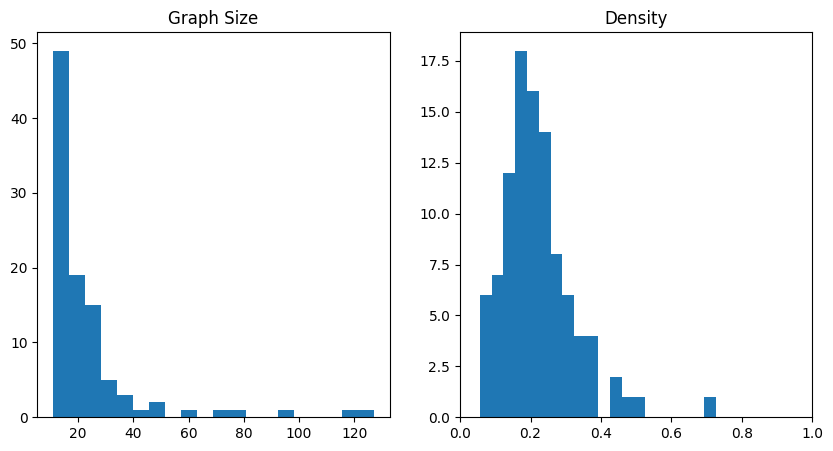

In [11]:
summarize(training_graphs)

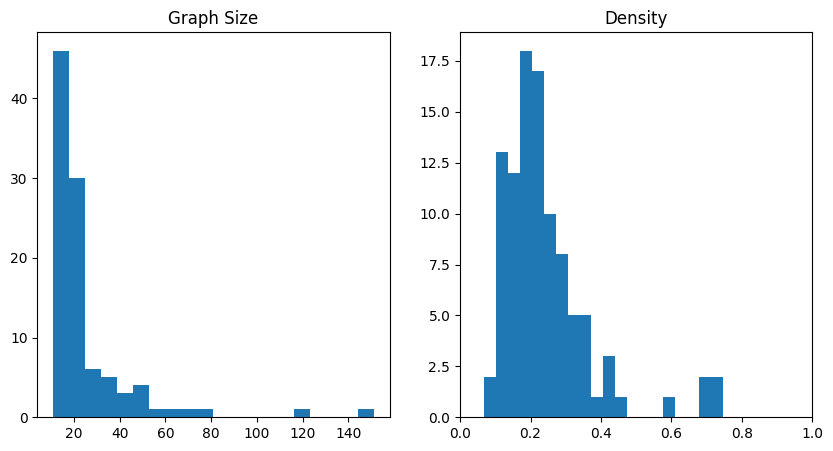

In [12]:
summarize(testing_graphs)

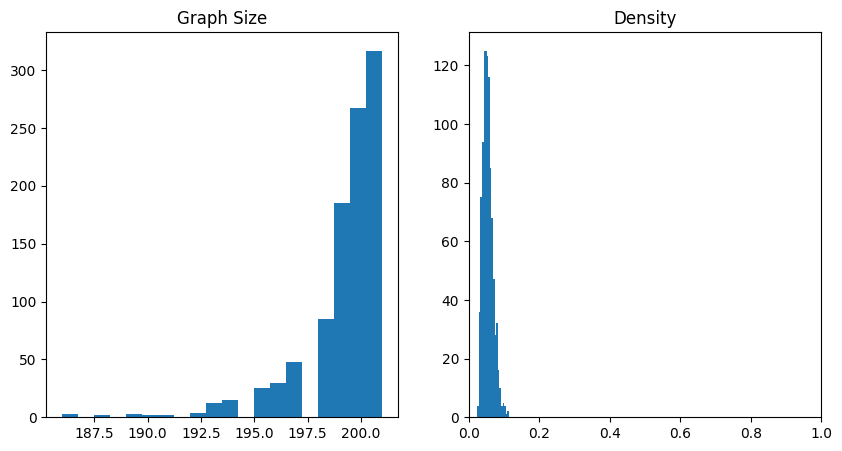

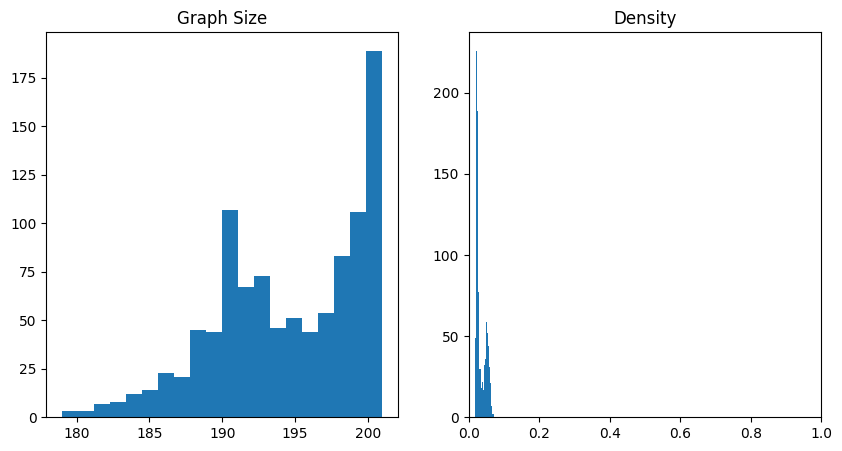

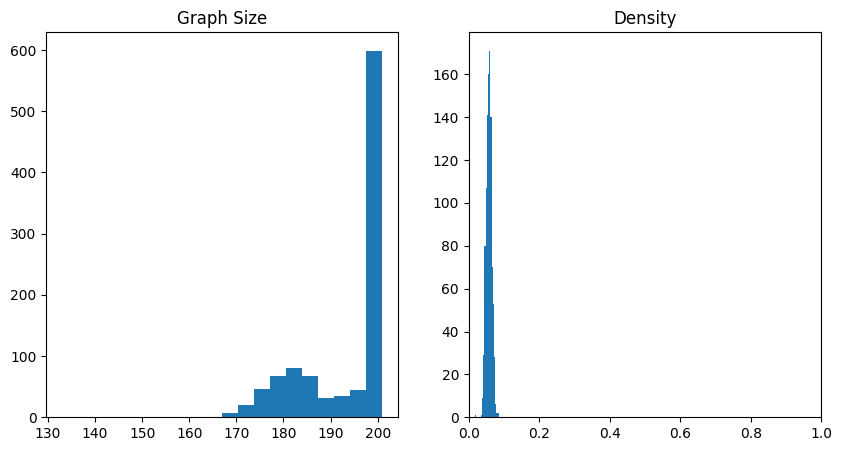

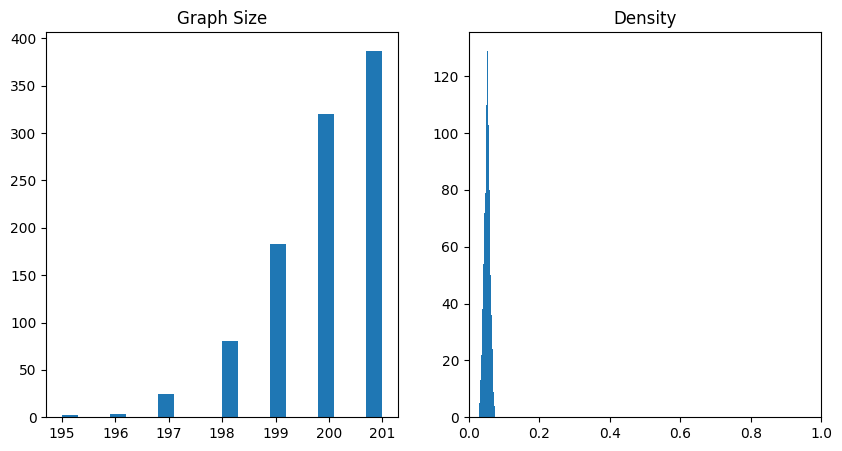

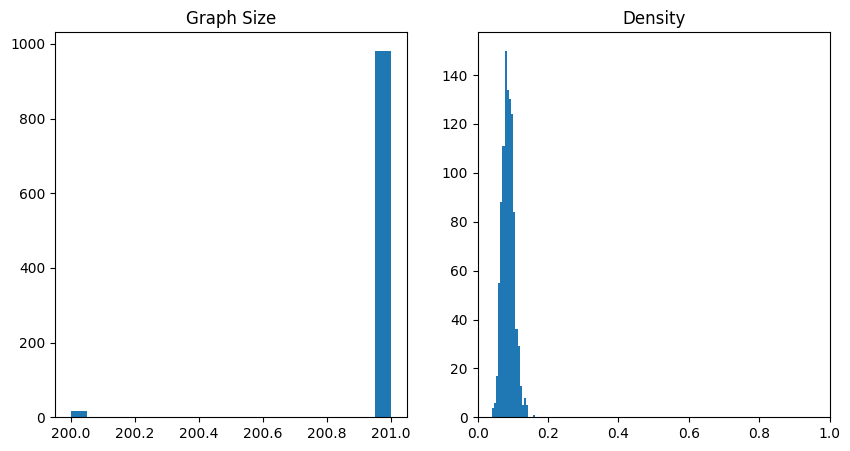

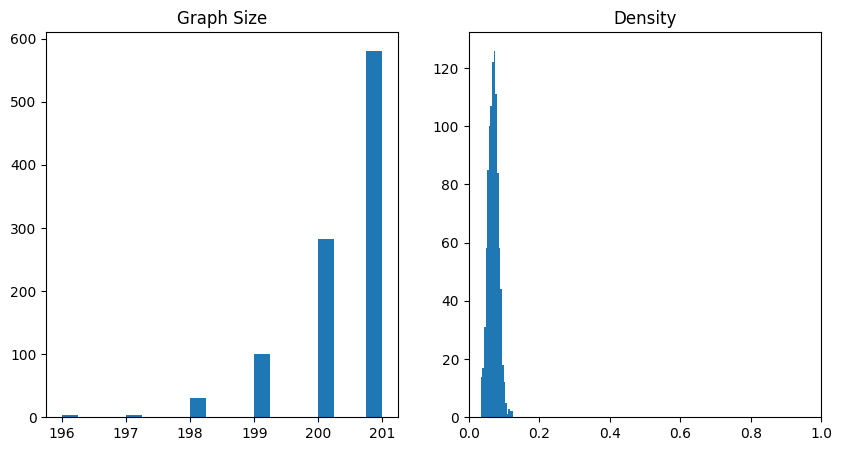

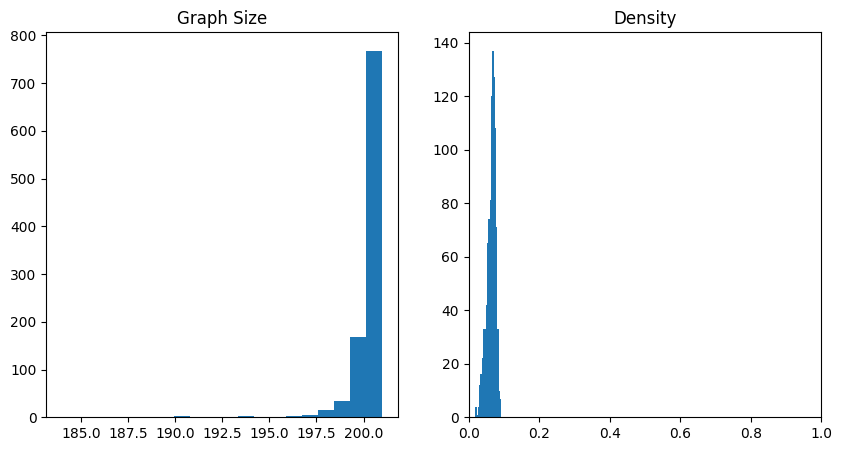

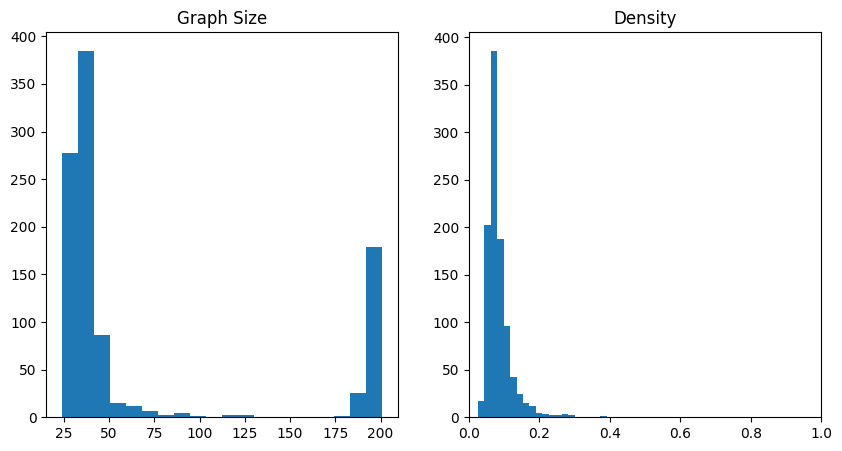

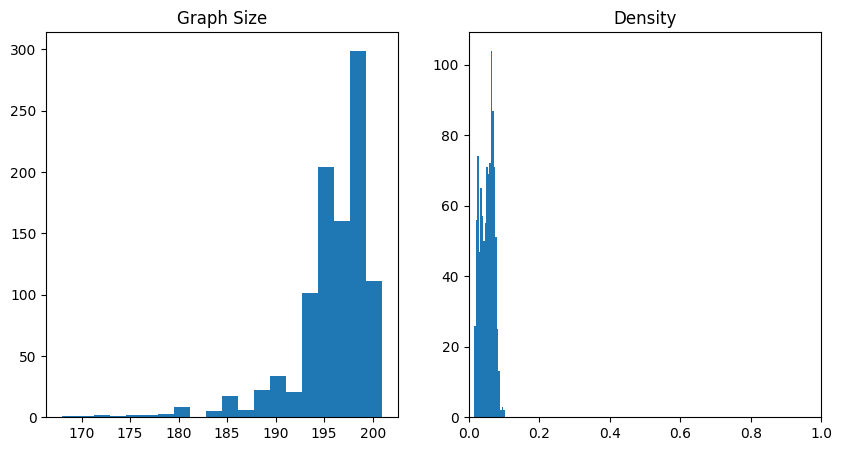

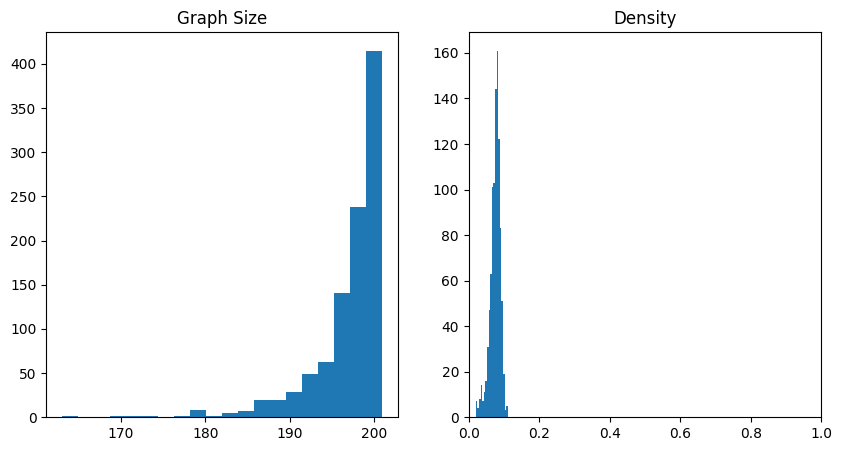

In [13]:
for sds in synthetic_datasets:
    summarize(sds)

Kernel stuff.

In [14]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [15]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

Privacy evaluation: we will use the max-similarity (max-kernel) score, which doesn't require any training.

In [16]:
from sklearn.metrics import roc_curve

In [17]:
def privacy_evaluation(synthetic_dataset, training_dataset, test_dataset):
    # Fit the kernel on the synthetic graphs.
    kernel.fit(_grak(synthetic_dataset))
    score_train = kernel.transform(_grak(training_dataset)).max(axis=1)
    score_test = kernel.transform(_grak(test_dataset)).max(axis=1)
    scores = np.concatenate((score_train, score_test))
    labels = np.array([1]*len(training_dataset) + [0]*len(test_dataset))
    plt.figure(figsize=(10, 5))
    # ROC curve for these scores.
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    # Distributions of scores
    plt.subplot(1, 2, 2)
    bins = np.linspace(np.min(scores), np.max(scores), 21)
    plt.hist(score_train, bins, facecolor='g', alpha=.5)
    plt.hist(score_test, bins, facecolor='r', alpha=.5)

Safety check: if the synthetic graphs are the training graphs, this should have perfect accuracy. Note that this also verifies that the testing and training datasets are disjoint.

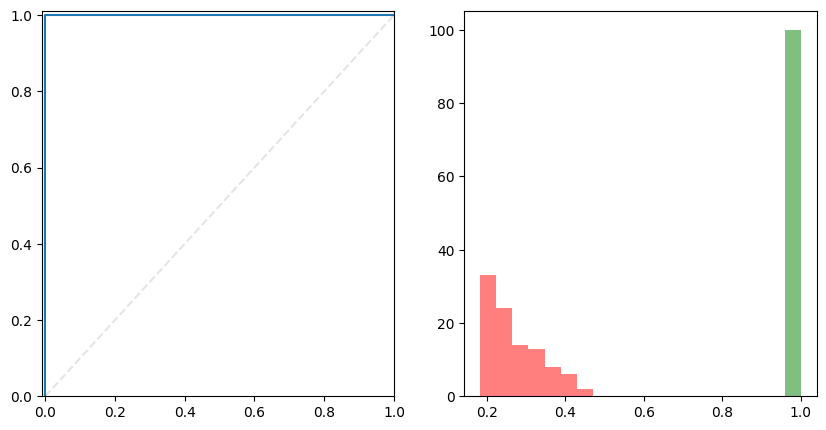

In [18]:
privacy_evaluation(training_graphs, training_graphs, testing_graphs)  # It does!

Moment of truth.

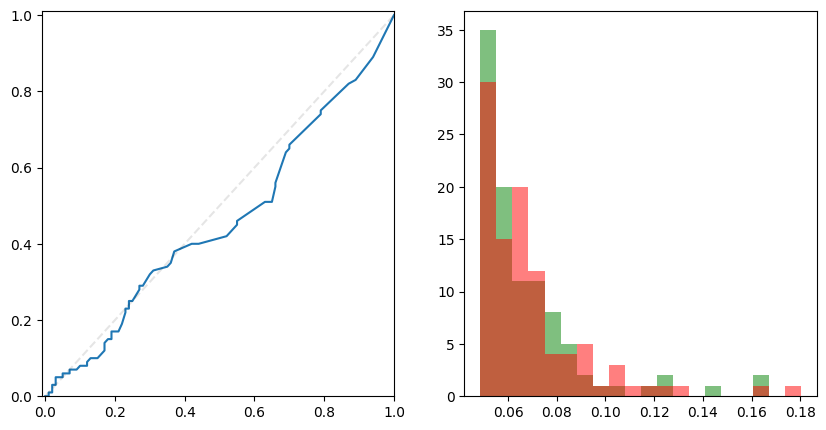

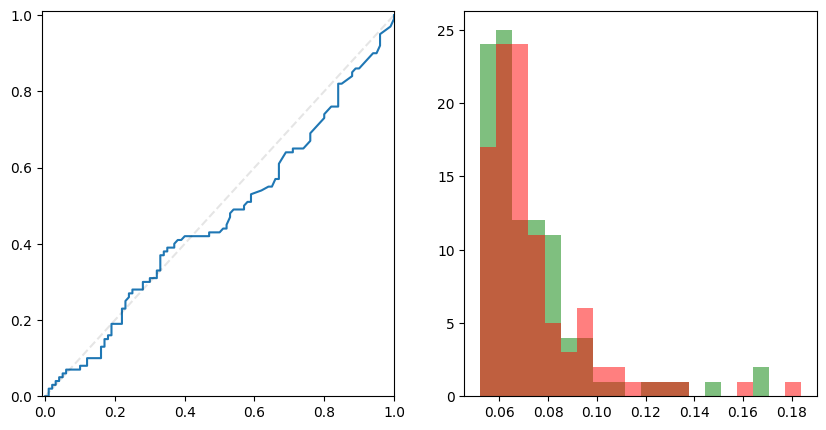

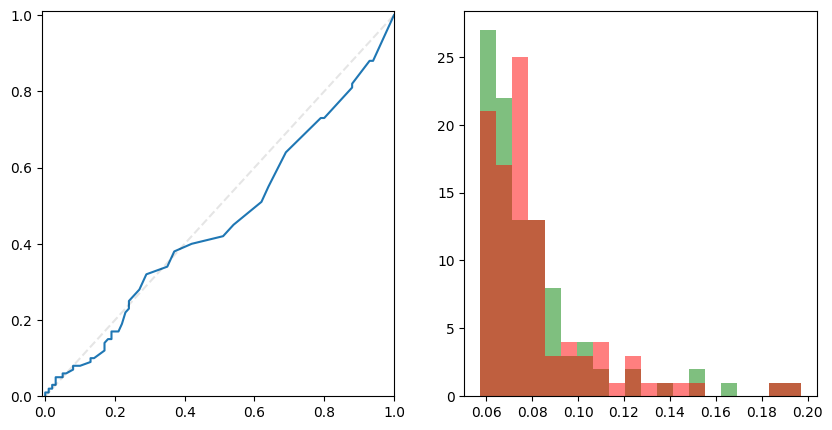

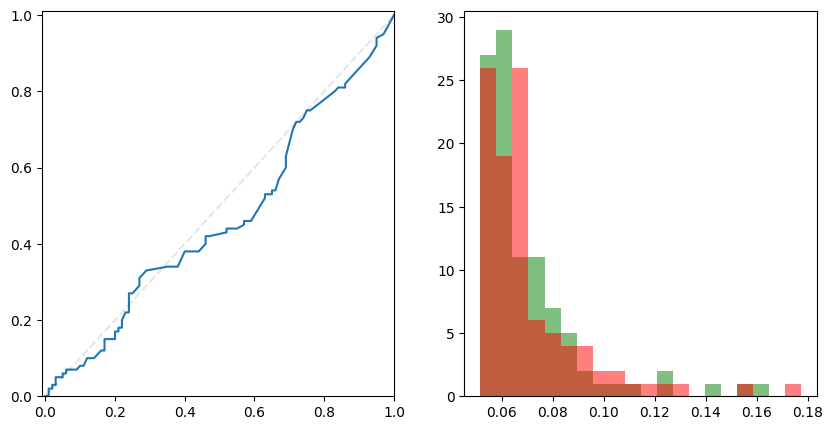

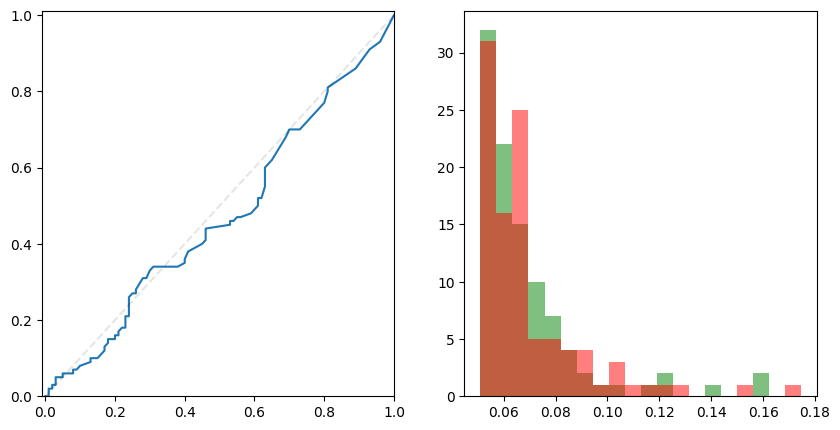

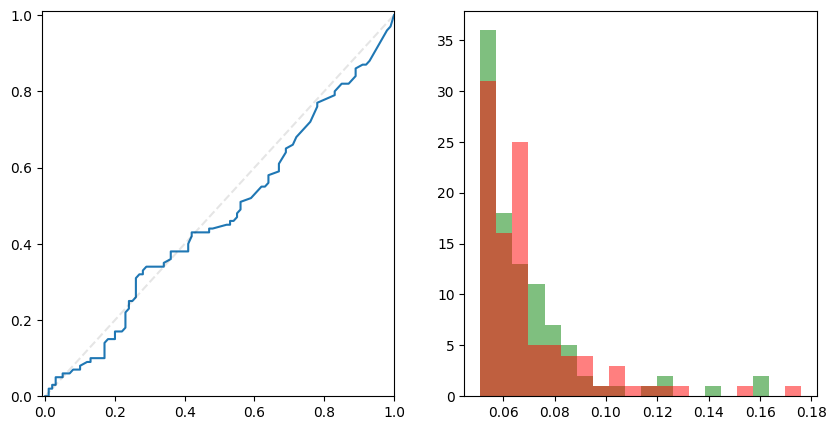

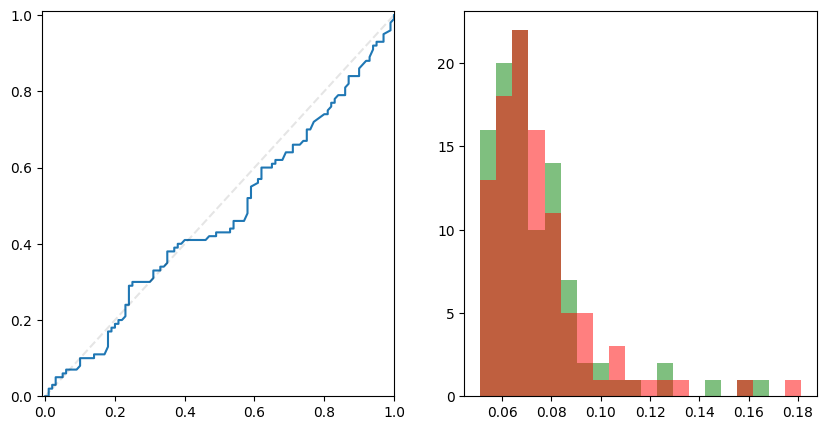

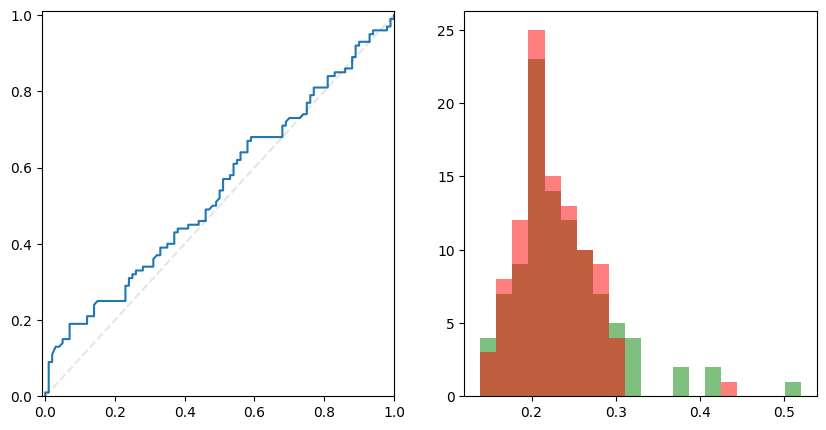

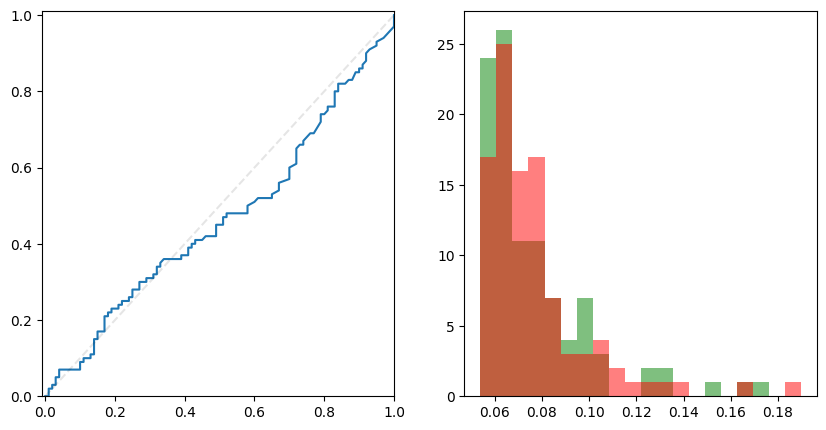

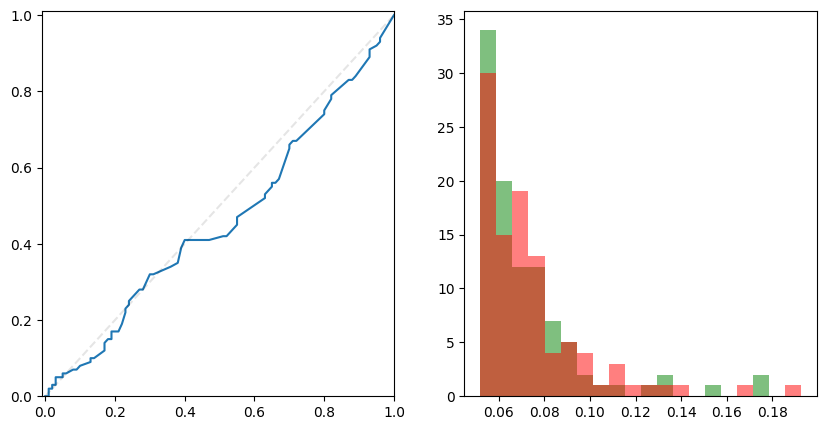

In [19]:
for sds in synthetic_datasets:
    privacy_evaluation(sds, training_graphs, testing_graphs)